In [1]:
import numpy as np
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape
from keras.layers import Input
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization_train, visualization_data
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.fashion_mnist import dataGenerator
from keras_lropt.callbacks import LRFinderAuto as LRFinder

Using TensorFlow backend.


# Parameters

In [2]:
num_class = 10
input_shape = (28, 28, 1)

batch_size = 32

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

# Model

In [4]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=128, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=16, capsule_dim=8, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=12, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(784, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       10496     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 576, 8)            1327232   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 12)            552960    
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 1,890,688
Trainable params: 1,890,688
Non-trainable params: 0
_________________________________________________________________


# Training

In [6]:
model_training.compile(optimizer=Adam(lr=1e-4),
                       loss=[margin(), mean_squared_error],
                       loss_weights=[1, 0.0005],
                       metrics={'capsule': 'accuracy'})

model.compile(optimizer=Adam(), loss=margin(), metrics=['accuracy'])

In [7]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
lrfinder = LRFinder(steps_per_epoch=60000 // batch_size)

Epoch 1/11
 - 140s - loss: 0.3623 - capsule_loss: 0.3623 - reconstruction_loss: 0.1258 - capsule_acc: 0.5359 - val_loss: 0.2369 - val_capsule_loss: 0.2369 - val_reconstruction_loss: 0.0544 - val_capsule_acc: 0.7414
Maximal learning rate: 0.0032708956894386145
Epoch 2/11
 - 141s - loss: 0.1994 - capsule_loss: 0.1994 - reconstruction_loss: 0.0639 - capsule_acc: 0.7200 - val_loss: 0.1384 - val_capsule_loss: 0.1384 - val_reconstruction_loss: 0.0498 - val_capsule_acc: 0.8049
Epoch 3/11
 - 142s - loss: 0.1264 - capsule_loss: 0.1264 - reconstruction_loss: 0.0521 - capsule_acc: 0.8253 - val_loss: 0.1087 - val_capsule_loss: 0.1087 - val_reconstruction_loss: 0.0464 - val_capsule_acc: 0.8522
Epoch 4/11
 - 141s - loss: 0.1080 - capsule_loss: 0.1080 - reconstruction_loss: 0.0490 - capsule_acc: 0.8504 - val_loss: 0.1022 - val_capsule_loss: 0.1021 - val_reconstruction_loss: 0.0447 - val_capsule_acc: 0.8590
Epoch 5/11
 - 141s - loss: 0.0988 - capsule_loss: 0.0988 - reconstruction_loss: 0.0471 - capsul

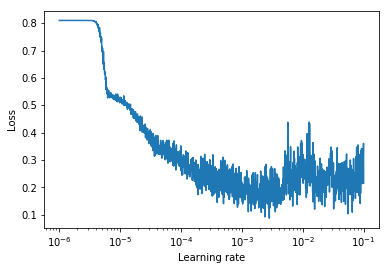

In [8]:
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=60000 // batch_size,
                                    epochs=10+1,
                                    validation_data=testGenerator,
                                    validation_steps=10000 // batch_size,
                                    verbose=2,
                                    callbacks=[history, lrfinder])

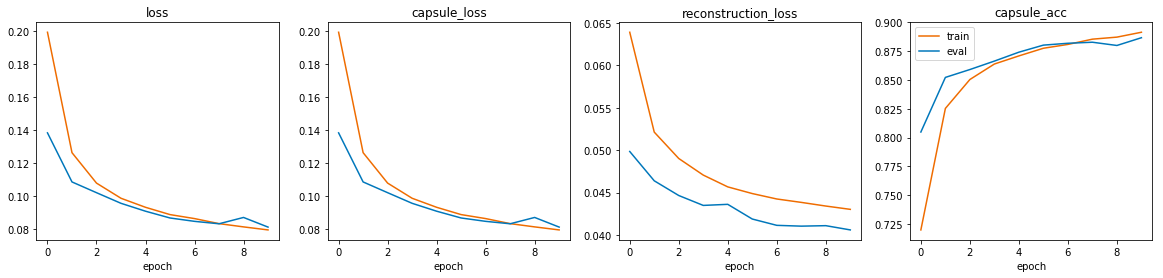

In [9]:
plotHistory(history.metrics)

# Training visualization

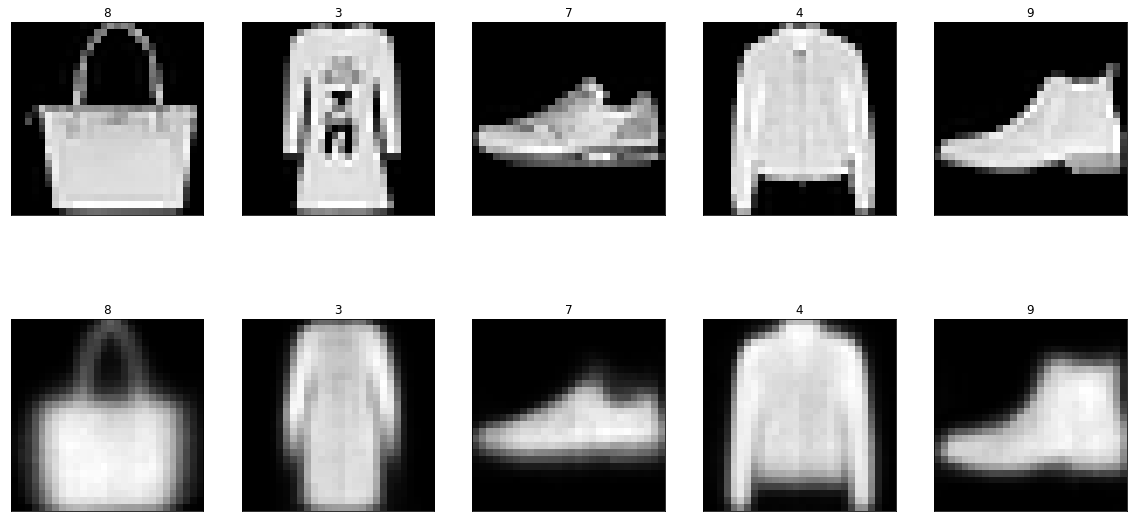

In [10]:
n_image = 5

# Select data
images, labels = next(dataGenerator('test', batch_size=n_image, reshape=False))

# Run inference
classes, reconstructions = model_training.predict([images, labels])

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)
images = images.reshape(-1, 28, 28)
reconstructions = reconstructions.reshape(-1, 28, 28)

visualization_train((images, labels), (reconstructions, predictions))

# Evaluation on augmented data

## Accuracy

In [11]:
data_augmentation = {
    'rotation_range': 30
}

# Select data
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False, **data_augmentation)

In [12]:
test_acc = model.evaluate_generator(testGenerator, steps=10000/32)[1]
print(f'Test acc: {round(test_acc, 3)} (augmented data)')

Test acc: 0.597 (augmented data)


## Visualization

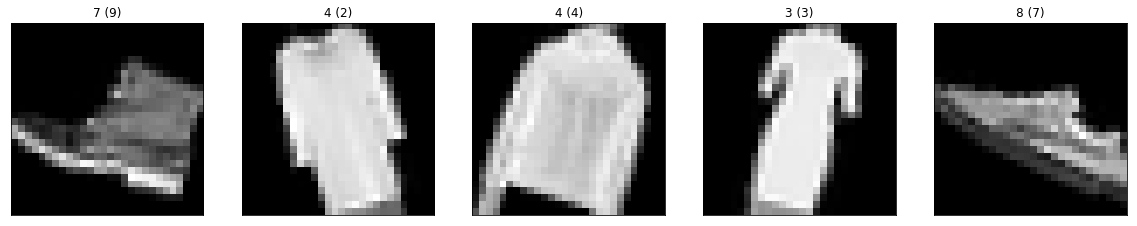

In [13]:
n_image=5

# Select data
testGenerator = dataGenerator('test', batch_size=n_image, reshape=False, **data_augmentation)
images, labels = next(testGenerator)

# Run inference
predictions = model.predict(images)

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(predictions, axis=1)
images = images.reshape((-1, 28, 28))

visualization_data(images, labels, predictions)